# Vehicle Detection Project

The steps of this project are the following:
1. Train a Linear SVM classifier to recognize cars, based on a Histogram of Oriented gradients (HOG) feature extraction,
2. Implement a sliding-window to search for vehicles in images, with the classifier trained previously,
3. Run the pipeline on the project video stream and create a heat map, to reject outliers and follow detected vehicles,
4. Estimate a bounding box for vehicles detected

In [29]:
# Import all required libraries
import os
import glob
import csv
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import numpy as np

%matplotlib inline

## 1. Train a linear SVM classifier to recognize cars

### a. Read labeled data

Number of 'car' images: 132150
Number of 'not car' images: 50760


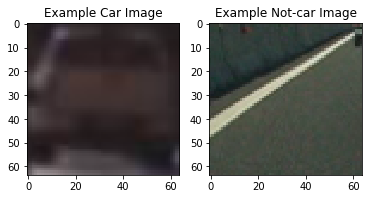

In [135]:
def display_random_images(cars, not_cars):
    car_ind = np.random.randint(0, len(cars))
    notcar_ind = np.random.randint(0, len(not_cars))

    img_reader, image = cars[car_ind]
    car_image = img_reader(image)

    img_reader, img_params = not_cars[notcar_ind]
    notcar_image = img_reader(img_params)

    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(car_image)
    plt.title('Example Car Image')
    plt.subplot(122)
    plt.imshow(notcar_image)
    plt.title('Example Not-car Image')

    
def load_labeled_images(cars=[], not_cars=[]):
    def img_reader(img_path):
        return mpimg.imread(img_path)
        
    images = glob.glob('data/*/*/*/*.png')
    for image in images:
        if 'non-vehicles' in image:
            not_cars.append( (img_reader, image) )
        else:
            cars.append( (img_reader, image) )
    
    return cars, not_cars


def load_annoted_driving_dataset1(cars=[], not_cars=[]):
    source_dir = ['data','object-detection-crowdai']
    def img_reader(img_params):
        xmin, xmax, ymin, ymax, Frame = img_params
        img = cv2.imread(os.path.join(*source_dir, Frame))
        return cv2.resize(img[xmax:ymax, xmin:ymin], (64,64))
    
    with open(os.path.join(*source_dir, 'labels.csv'), newline='') as f:
        reader = csv.DictReader(f, delimiter=',', quoting=csv.QUOTE_NONE)
        for row in reader:
            xmin, xmax, ymin, ymax, Frame, Label = row['xmin'], row['xmax'], row['ymin'], row['ymax'], row['Frame'], row['Label']
            xmin, xmax, ymin, ymax = tuple(map(int, (xmin, xmax, ymin, ymax)))
            
            if Label == 'Car':
                cars.append( (img_reader, (xmin, xmax, ymin, ymax, Frame)) )
            else:
                not_cars.append( (img_reader, (xmin, xmax, ymin, ymax, Frame)) )
            
    return cars, not_cars


def load_annoted_driving_dataset2(cars=[], not_cars=[]):
    source_dir = ['data','object-dataset']
    def img_reader(img_params):
        xmin, xmax, ymin, ymax, Frame = img_params
        xmin, xmax, ymin, ymax = tuple(map(int, (xmin, xmax, ymin, ymax)))
        img = cv2.imread(os.path.join(*source_dir, Frame))
        return cv2.resize(img[ymin:ymax, xmin:xmax], (64,64))
    
    with open(os.path.join(*source_dir, 'labels.csv'), newline='') as f:
        reader = csv.reader(f, delimiter=' ', quoting=csv.QUOTE_MINIMAL)
        # frame xmin ymin xmax ymax occluded label attributes(Only appears on traffic lights)
        for row in reader:
            frame, xmin, ymin, xmax, ymax, occluded, label = row[0], row[1], row[2], row[3], row[4], row[5], row[6]
            xmin, xmax, ymin, ymax = tuple(map(int, (xmin, xmax, ymin, ymax)))
            
            if label.lower() == 'car':
                cars.append( (img_reader, (xmin, xmax, ymin, ymax, frame)) )
            else:
                not_cars.append( (img_reader, (xmin, xmax, ymin, ymax, frame)) )
            
    return cars, not_cars

cars, not_cars = load_labeled_images()
load_annoted_driving_dataset1(cars, not_cars)
load_annoted_driving_dataset2(cars, not_cars)

print('Number of \'car\' images:', len(cars))
print('Number of \'not car\' images:', len(not_cars))

display_random_images(cars, not_cars)